# Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

# Load and inflate prices

In [2]:
df = pd.read_csv("data/coords/coords_HDB.csv")

#use of cpi to deflate/inflate prices as next best tool since unable to locate ooa stats online
cpi = pd.read_csv("data/cpi.csv")
cpi.head()

,year,level_1,value
0,1990,MAS Core Inflation Measure,62.094
1,1991,MAS Core Inflation Measure,64.359
2,1992,MAS Core Inflation Measure,65.398
3,1993,MAS Core Inflation Measure,66.562
4,1994,MAS Core Inflation Measure,68.246


In [3]:
#base yr in 2019
print(cpi[cpi.value==100])

#2014 base value
cpi.value[cpi.year==2014]

    year                     level_1  value
29  2019  MAS Core Inflation Measure  100.0


24    94.607
Name: value, dtype: float64

In [4]:
#rebase it to 2014 to try predict prices in 2015
cpi['new_value'] = cpi['value']/94.607*100
cpi.iloc[24]['new_value']

100.0

In [5]:
#merge df
merged = pd.merge(df, cpi, how='left', left_on='year_sold', right_on='year')

#inflate/deflate all prices
merged['new_resale_price'] = merged['resale_price'] / merged['new_value'] *100
merged.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,year_sold,mth_sold,age_sold,lat,long,year,level_1,value,new_value,new_resale_price
0,ANG MO KIO,4 ROOM,211,ANG MO KIO AVE 3,04 TO 06,81.0,NEW GENERATION,80000.0,1990,1,13.0,1.369197,103.841667,1990.0,MAS Core Inflation Measure,62.094,65.633621,121888.749316
1,ANG MO KIO,4 ROOM,209,ANG MO KIO AVE 3,07 TO 09,91.0,NEW GENERATION,72000.0,1990,1,13.0,1.368971,103.843285,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384
2,ANG MO KIO,4 ROOM,231,ANG MO KIO AVE 3,04 TO 06,92.0,NEW GENERATION,72000.0,1990,1,13.0,1.368561,103.837525,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384
3,ANG MO KIO,4 ROOM,308,ANG MO KIO AVE 1,10 TO 12,92.0,NEW GENERATION,86000.0,1990,1,14.0,1.365697,103.844347,1990.0,MAS Core Inflation Measure,62.094,65.633621,131030.405514
4,ANG MO KIO,4 ROOM,254,ANG MO KIO AVE 4,10 TO 12,97.0,NEW GENERATION,72000.0,1990,1,13.0,1.370203,103.834688,1990.0,MAS Core Inflation Measure,62.094,65.633621,109699.874384


In [6]:
#only the specified 3 columns and year (for weightage) can be used for predicting price
merged = merged.filter(["flat_type", "age_sold", "town", "new_resale_price", "year_sold"])

#extract only data before 2015 to prevent data leakage
#2010 chosen as cutoff for its proximity of year and number of samples for training
#2011-3 and prior for training/CV; 2014 data for testing
train = merged.where((merged.year_sold>=2011) & (merged.year_sold<2014))
train.dropna(inplace=True)

test = merged.where(merged.year_sold==2014)
test.dropna(inplace=True)

print(train.shape)
print(test.shape) #about 25.7% of train data

(61303, 5)
(15762, 5)


In [7]:
merged = merged.where((merged.year_sold>=2011) & (merged.year_sold<2015))
merged.corr()

,age_sold,new_resale_price,year_sold
age_sold,1.000000,-0.450963,0.116494
new_resale_price,-0.450963,1.000000,-0.011721
year_sold,0.116494,-0.011721,1.000000


# Visualisation

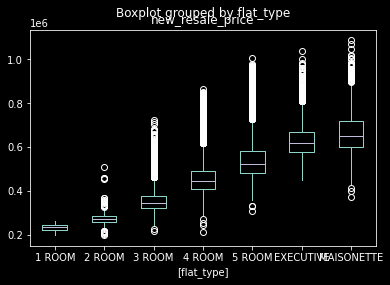

In [8]:
#see distribution
merged.boxplot(by =["flat_type"], column =['new_resale_price'], grid = False);

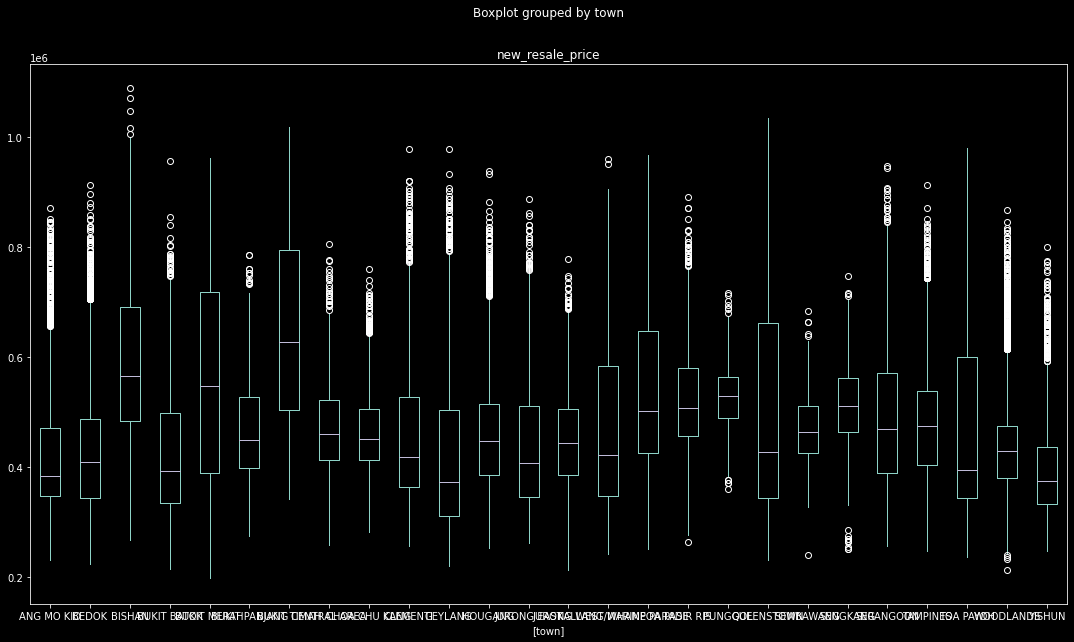

In [9]:
merged.boxplot(by =["town"], column =['new_resale_price'], figsize = (18,10), grid = False);

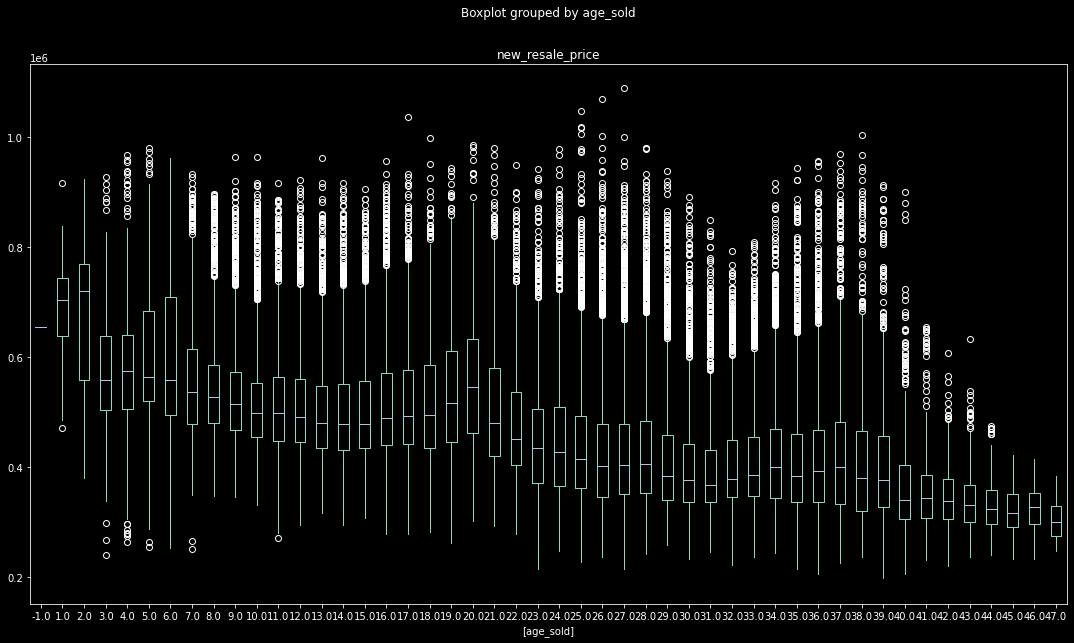

In [10]:
merged.boxplot(by =["age_sold"], column =['new_resale_price'], figsize = (18,10), grid = False);

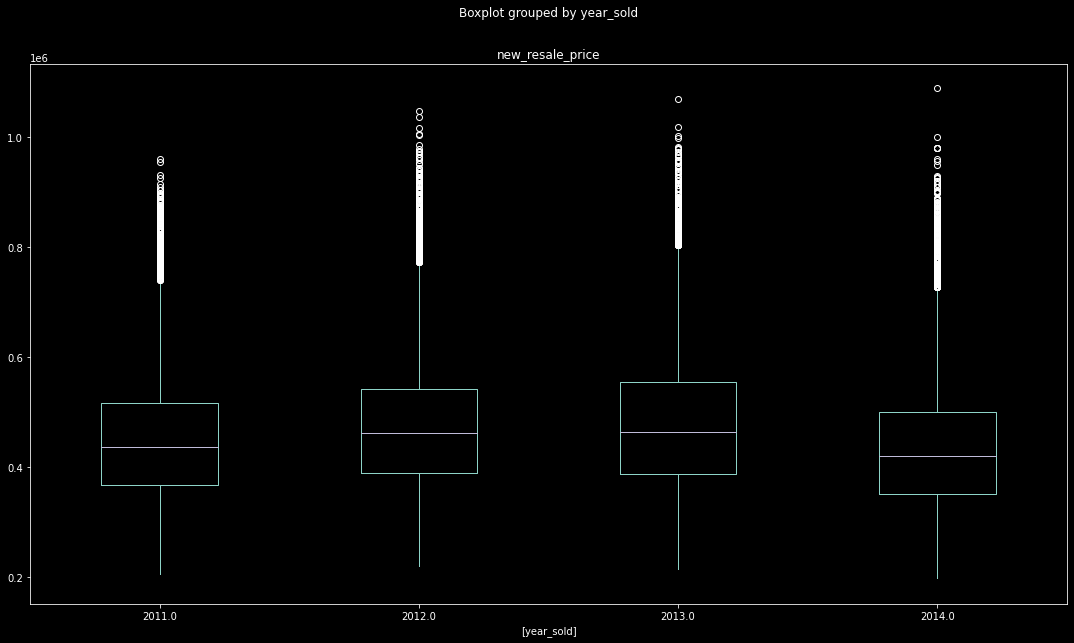

In [11]:
merged.boxplot(by =["year_sold"], column =['new_resale_price'], figsize = (18,10), grid = False);
#to ignore the possible data entry errors for age<0

# Data Preparation

In [12]:
#Add dummy variables to categorical data
merged = pd.get_dummies(data=merged, drop_first=True)

In [13]:
merged.corr()

,age_sold,new_resale_price,year_sold,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MAISONETTE,town_BEDOK,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
age_sold,1.000000,-0.450963,0.116494,0.145032,0.580510,-0.211968,-0.332056,-0.170546,0.006181,0.172401,...,-0.063221,-0.245134,0.139443,-0.182519,-0.320116,0.028079,0.026570,0.153405,-0.152383,0.078760
new_resale_price,-0.450963,1.000000,-0.011721,-0.165459,-0.581307,-0.004720,0.388095,0.319218,0.293922,-0.065802,...,0.094806,0.087504,0.042858,0.006622,0.103747,0.031899,0.037981,0.002361,-0.074198,-0.158685
year_sold,0.116494,-0.011721,1.000000,0.000874,0.025498,0.017596,-0.035639,-0.015664,-0.010643,0.017041,...,-0.002538,-0.008419,0.005854,-0.005787,0.000727,0.000841,0.011373,-0.000078,-0.016187,0.010133
flat_type_2 ROOM,0.145032,-0.165459,0.000874,1.000000,-0.005138,-0.005908,-0.004575,-0.002150,-0.001637,0.034741,...,-0.000396,-0.001567,0.113037,-0.000663,0.002748,0.006107,-0.002505,0.062820,0.004290,-0.002448
flat_type_3 ROOM,0.580510,-0.581307,0.025498,-0.005138,1.000000,-0.030642,-0.023730,-0.011150,-0.008489,0.212018,...,-0.005690,-0.008125,0.174665,-0.007563,-0.007751,0.070869,0.116033,0.172862,0.056799,0.169091
flat_type_4 ROOM,-0.211968,-0.004720,0.017596,-0.005908,-0.030642,1.000000,-0.027288,-0.012821,-0.009761,0.120378,...,0.115999,0.086569,0.054315,0.101068,0.166424,0.098025,0.168476,0.073080,0.199609,0.185469
flat_type_5 ROOM,-0.332056,0.388095,-0.035639,-0.004575,-0.023730,-0.027288,1.000000,-0.009929,-0.007559,0.068287,...,0.110204,0.195548,0.027640,0.123584,0.209010,0.040492,0.116321,0.039212,0.186973,0.052977
flat_type_EXECUTIVE,-0.170546,0.319218,-0.015664,-0.002150,-0.011150,-0.012821,-0.009929,1.000000,-0.003552,0.017646,...,0.170137,0.048310,-0.000974,0.106066,0.114369,0.026263,0.047652,0.005088,0.099780,0.019322
flat_type_MAISONETTE,0.006181,0.293922,-0.010643,-0.001637,-0.008489,-0.009761,-0.007559,-0.003552,1.000000,0.027158,...,0.054734,-0.002588,0.001485,0.005787,0.002013,0.067403,0.073345,0.015708,0.042642,0.029979
town_BEDOK,0.172401,-0.065802,0.017041,0.034741,0.212018,0.120378,0.068287,0.017646,0.027158,1.000000,...,-0.004172,-0.003768,-0.003749,-0.003507,-0.005540,-0.003347,-0.006026,-0.004110,-0.006729,-0.005887


In [14]:
#set model weights based on year sold and subsequently use that column as weight
merged['year_sold'] = np.where(merged['year_sold'] == 2011, 50, merged['year_sold'])
merged['year_sold'] = np.where(merged['year_sold'] == 2012, 20, merged['year_sold'])
merged['year_sold'] = np.where(merged['year_sold'] == 2013, 30, merged['year_sold'])

In [15]:
#Split train test set
train = merged.where((merged.year_sold>=20) & (merged.year_sold<=50))
train.dropna(inplace=True)

test = merged.where(merged.year_sold==2014)
test.dropna(inplace=True)

In [16]:
X_train = train.drop(['new_resale_price', 'year_sold'], axis=1)
X_train_weights = pd.DataFrame(train["year_sold"]).to_numpy()
X_test  = test.drop(['new_resale_price', 'year_sold'], axis=1)

y_train = train['new_resale_price']
y_test  = test['new_resale_price']

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

def run_LR(weighted):
    #fit model
    model = LinearRegression()
    if weighted:
        model.fit(X_train,y_train, X_train_weights.ravel())
    else:
        model.fit(X_train,y_train)
    predictions = model.predict(X_test)

    #assess model
    RMSE = mean_squared_error(y_test, predictions, squared=False)
    R2 = r2_score(y_test, predictions)
    return RMSE, R2, model

In [18]:
RMSE, R2, model = run_LR(False)
print("Unweighted LR model RMSE = ", RMSE, "; R2 = ", R2)

RMSE, R2, model = run_LR(True)
print("Weighted LR model RMSE = ", RMSE, "; R2 = ", R2)

Unweighted LR model RMSE =  56675.50532587449 ; R2 =  0.7832637591660174
Weighted LR model RMSE =  55653.431251371054 ; R2 =  0.7910104237840162


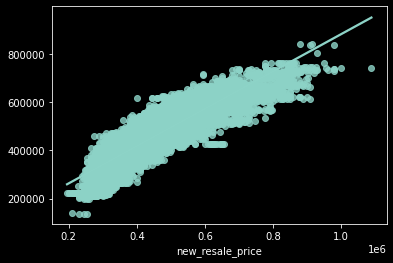

In [19]:
predictions = model.predict(X_test)
sns.regplot(x=y_test,y=predictions);

# XGBoost

In [20]:
#using most popular model to try
from xgboost import XGBRegressor
xgb = XGBRegressor(eval_metric = "rmse").fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)

print("\nTrain RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = xgb.predict(X_test)
print("\nTest RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn RandomForestRegressor model: 40747.806
Train R2 using sklearn RandomForestRegressor model: 1.0

Test RMSE using sklearn RandomForestRegressor model: 54998.465
Test R2 using sklearn RandomForestRegressor model: 1.0


# Random Forest

In [21]:
#try using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
print("\nTrain RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = rf.predict(X_test)
print("\nTest RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn RandomForestRegressor model: 38810.671
Train R2 using sklearn RandomForestRegressor model: 1.0

Test RMSE using sklearn RandomForestRegressor model: 58481.553
Test R2 using sklearn RandomForestRegressor model: 1.0


In [22]:
#we categorise new_resale_price as range of price in blocks of 10k to try reduce overfitting
train['new_resale_cat'] = np.floor(train['new_resale_price']/10000).astype(int)
test['new_resale_cat'] = np.floor(test['new_resale_price']/10000).astype(int)

X_train = train.drop(['new_resale_price', 'year_sold', 'new_resale_cat'], axis=1)
X_test  = test.drop(['new_resale_price', 'year_sold', 'new_resale_cat'], axis=1)

y_train = train['new_resale_cat']
y_test  = test['new_resale_cat']

In [23]:
rf = RandomForestRegressor().fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
print("\nTrain RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = rf.predict(X_test)
print("\nTest RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn RandomForestRegressor model: 3.891
Train R2 using sklearn RandomForestRegressor model: 1.0

Test RMSE using sklearn RandomForestRegressor model: 5.752
Test R2 using sklearn RandomForestRegressor model: 1.0


In [24]:
#hyper-parameterise the model using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [3, 5, 10],
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2']    
}

model_Grid = GridSearchCV(estimator = RandomForestRegressor(n_jobs=-1),
                        param_grid = param_grid,
                        scoring = 'neg_root_mean_squared_error',
                        n_jobs = -1, cv=5,
                        verbose=5)

model_Grid.fit(X_train, y_train)
print("Best hyper-parameters =", model_Grid.best_params_)
print("Best RSME score =", model_Grid.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyper-parameters = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 5}
Best RSME score = -5.1469824579746515


In [25]:
y_pred_train = model_Grid.predict(X_train)
print("\nTrain RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print("Train R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_train, y_pred_train),0))

y_pred_test = model_Grid.predict(X_test)
print("\nTest RMSE using sklearn RandomForestRegressor model:",
round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print("Test R2 using sklearn RandomForestRegressor model:",
round(r2_score(y_test, y_pred_test),0))


Train RMSE using sklearn RandomForestRegressor model: 4.161
Train R2 using sklearn RandomForestRegressor model: 1.0

Test RMSE using sklearn RandomForestRegressor model: 5.531
Test R2 using sklearn RandomForestRegressor model: 1.0
